
# Exoplanet Baseline Models — 75/25 Split (GB, XGBoost, LightGBM)

This notebook trains and evaluates three classifiers on the Kepler KOI transit + host-star features:

- **GradientBoostingClassifier** (scikit-learn)  
- **XGBClassifier** (XGBoost)  
- **LGBMClassifier** (LightGBM)

It uses a **75/25 train/test split**, prints metrics, plots confusion matrices, shows feature importances,
and saves each model (with metadata) as a **pickle (.pkl)** for later use.

> **Note:** If `xgboost` or `lightgbm` are missing in your environment, the install cell below attempts to install them.


In [12]:
# If running locally and these aren't installed, uncomment the lines below.
# It’s okay if installation fails in offline environments; XGBoost/LightGBM/RandomForest cells will be skipped.

try:
    import xgboost  # noqa: F401
except Exception:
    try:
        %pip install xgboost -q
    except Exception as e:
        print("xgboost install failed or not permitted in this environment:", e)

try:
    import lightgbm  # noqa: F401
except Exception:
    try:
        %pip install lightgbm -q
    except Exception as e:
        print("lightgbm install failed or not permitted in this environment:", e)

try:
    from sklearn.ensemble import RandomForestClassifier  # noqa: F401
except Exception:
    try:
        %pip install scikit-learn -q
    except Exception as e:
        print("scikit-learn (for RandomForest) install failed or not permitted in this environment:", e)


In [13]:
import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import GradientBoostingClassifier

# ------------------------------------------------------------
# Optional imports guarded for environments where packages are not available
# ------------------------------------------------------------

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print("XGBoost not available — skipping XGBoost model.")

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False
    print("LightGBM not available — skipping LightGBM model.")

try:
    from sklearn.ensemble import RandomForestClassifier
    HAS_RF = True
except Exception:
    HAS_RF = False
    print("RandomForest not available — skipping RandomForest model.")


In [3]:

# === Config ===
data_path  = "data/Kepler Object of Interest.xlsx"  # change to your file
target_col = "koi_disposition"
feature_cols = [
    "koi_period","koi_time0bk","koi_duration","koi_depth",
    "koi_prad","koi_teq","koi_steff","koi_slogg","koi_srad","koi_kepmag"
]
id_cols = ["kepid", "kepler_name"]  # kept for traceability (not used as features)

# --- Load (Excel or CSV) ---
ext = os.path.splitext(data_path)[1].lower()
if ext in (".xls", ".xlsx"):
    df_raw = pd.read_excel(data_path)
else:
    df_raw = pd.read_csv(data_path)

# --- Normalize column names (strip spaces) ---
df_raw.columns = df_raw.columns.astype(str).str.strip()

# --- Validate required columns exist ---
required = set([target_col] + feature_cols)
missing = sorted(required - set(df_raw.columns))
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# --- Select cols: IDs (if present) + target + features ---
present_id_cols = [c for c in id_cols if c in df_raw.columns]
df = df_raw[present_id_cols + [target_col] + feature_cols].copy()

# --- Coerce feature dtypes to numeric (safe) ---
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- Drop rows with NA in target or any feature ---
before = len(df)
df = df.dropna(subset=[target_col] + feature_cols).reset_index(drop=True)
dropped = before - len(df)

# --- Display quick sanity info ---
display(df.head())
print(f"Rows kept: {len(df)}  |  Dropped due to NA: {dropped}")
if present_id_cols:
    print(f"ID columns retained (not used as features): {present_id_cols}")


,kepid,kepler_name,koi_disposition,koi_period,koi_time0bk,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,10797460,Kepler-227 b,CONFIRMED,9.488036,170.538750,2.95750,615.8,2.26,793.0,5455.0,4.467,0.927,15.347
1,10797460,Kepler-227 c,CONFIRMED,54.418383,162.513840,4.50700,874.8,2.83,443.0,5455.0,4.467,0.927,15.347
2,10811496,NaN,CANDIDATE,19.899140,175.850252,1.78220,10829.0,14.60,638.0,5853.0,4.544,0.868,15.436
3,10848459,NaN,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,33.46,1395.0,5805.0,4.564,0.791,15.597
4,10854555,Kepler-664 b,CONFIRMED,2.525592,171.595550,1.65450,603.3,2.75,1406.0,6031.0,4.438,1.046,15.509


Rows kept: 9200  |  Dropped due to NA: 364
ID columns retained (not used as features): ['kepid', 'kepler_name']


In [4]:

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# --- Encode target (stable, explicit str cast) ---
le = LabelEncoder()
y = le.fit_transform(df[target_col].astype(str))

# --- Features as DataFrame (preserve column names for later) ---
X = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# --- Carry IDs (if present) for traceability through splits/predictions ---
id_cols = [c for c in ["kepid", "kepler_name"] if c in df.columns]
ids = df[id_cols].copy() if id_cols else pd.DataFrame(index=df.index)

# --- Class mapping & distribution ---
label_ids = np.arange(len(le.classes_))
class_map = dict(zip(le.classes_, label_ids))

counts = pd.Series(y).value_counts().sort_index()  # aligned with label_ids
dist_df = pd.DataFrame({
    "label_id": label_ids,
    "label": le.classes_,
    "count": counts.values,
    "proportion": (counts.values / counts.values.sum()).round(4)
})

# Optional: class weights (handy for imbalanced classes)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=label_ids,
    y=y
)
class_weight_map = {lbl: wt for lbl, wt in zip(le.classes_, class_weights)}

print("Class mapping (label -> id):", class_map)
print("Class weights (balanced):", class_weight_map)
print("Distribution:\n", dist_df.to_string(index=False))


Class mapping (label -> id): {'CANDIDATE': np.int64(0), 'CONFIRMED': np.int64(1), 'FALSE POSITIVE': np.int64(2)}
Class weights (balanced): {'CANDIDATE': np.float64(1.6355555555555557), 'CONFIRMED': np.float64(1.1175898931000972), 'FALSE POSITIVE': np.float64(0.669431710689078)}
Distribution:
  label_id          label  count  proportion
        0      CANDIDATE   1875      0.2038
        1      CONFIRMED   2744      0.2983
        2 FALSE POSITIVE   4581      0.4979


In [5]:
from sklearn.model_selection import train_test_split

# === Train/Test Split (75/25) ===
# Stratify by y if multiple classes to maintain class balance
stratify_opt = y if len(np.unique(y)) > 1 else None

# Split X, y, and IDs together to preserve alignment
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids,
    test_size=0.25,
    random_state=42,
    stratify=stratify_opt
)

# Confirm shapes and alignment
print(f"Train: {X_train.shape},  Test: {X_test.shape}")
print(f"Train IDs: {len(ids_train)},  Test IDs: {len(ids_test)}")

# Sanity check — ensure alignment between features and IDs
assert X_test.index.equals(ids_test.index), "❌ Index mismatch: IDs not aligned with X_test"
assert X_train.index.equals(ids_train.index), "❌ Index mismatch: IDs not aligned with X_train"

# Reset index for clean saves later (e.g., when exporting test sample)
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
ids_train = ids_train.reset_index(drop=True)
ids_test  = ids_test.reset_index(drop=True)


Train: (6900, 10),  Test: (2300, 10)
Train IDs: 6900,  Test IDs: 2300


In [10]:
# ================================================
# 📦 Save test data for future app-based evaluation
# ================================================
import os

# Create data folder if not exists
os.makedirs("data/koi_testing_sample", exist_ok=True)

# Convert to DataFrame for readability
X_test_df = pd.DataFrame(X_test, columns=feature_cols)
y_test_labels = le.inverse_transform(y_test)
y_test_df = pd.DataFrame({
    "koi_disposition": y_test_labels
})

# Save both to CSV for app loading
X_test_path = "data/koi_testing_sample/X_test.csv"
y_test_path = "data/koi_testing_sample/y_test.csv"

X_test_df.to_csv(X_test_path, index=False)
y_test_df.to_csv(y_test_path, index=False)

print(f"💾 Saved test feature sample: {X_test_path}")
print(f"💾 Saved test labels: {y_test_path}")

💾 Saved test feature sample: data/koi_testing_sample/X_test.csv
💾 Saved test labels: data/koi_testing_sample/y_test.csv


In [6]:

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Build model zoo (4 models; XGB/LGBM are optional if available)
# ------------------------------------------------------------
models = {
    "gradient_boosting": GradientBoostingClassifier(random_state=42),
    "random_forest": RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
    ),
}

if 'HAS_XGB' in globals() and HAS_XGB:
    models["xgboost"] = XGBClassifier(
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
    )

if 'HAS_LGBM' in globals() and HAS_LGBM:
    models["lightgbm"] = LGBMClassifier(
        random_state=42,
        n_estimators=600,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        n_jobs=-1,
    )

print("Models to train:", list(models.keys()))

# ------------------------------------------------------------
# Optional: class-balanced sample weights (helps if labels imbalanced)
# ------------------------------------------------------------
label_ids = np.arange(len(le.classes_))
cls_w = compute_class_weight(class_weight="balanced", classes=label_ids, y=y_train)
sample_weights = cls_w[y_train]  # index by class id per row

# ------------------------------------------------------------
# Train, predict, evaluate
# ------------------------------------------------------------
results_summary = []
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    # Most sklearn + XGB/LGBM classifiers accept sample_weight in fit
    try:
        model.fit(X_train, y_train, sample_weight=sample_weights)
    except TypeError:
        # Fallback if a model doesn't support sample_weight for some reason
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"{name} accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=list(le.classes_)))
    results_summary.append({"model": name, "accuracy": acc})

# ------------------------------------------------------------
# Quick leaderboard + model keys
# ------------------------------------------------------------
leaderboard = pd.DataFrame(results_summary).sort_values("accuracy", ascending=False)
print("\nModel leaderboard (by accuracy):")
print(leaderboard.to_string(index=False))

print("\nlist(models.keys()):", list(models.keys()))



Models to train: ['gradient_boosting', 'random_forest', 'xgboost', 'lightgbm']

=== Training: gradient_boosting ===
gradient_boosting accuracy: 0.7365
                precision    recall  f1-score   support

     CANDIDATE       0.49      0.69      0.57       469
     CONFIRMED       0.76      0.81      0.78       686
FALSE POSITIVE       0.90      0.71      0.79      1145

      accuracy                           0.74      2300
     macro avg       0.72      0.74      0.72      2300
  weighted avg       0.77      0.74      0.75      2300


=== Training: random_forest ===
random_forest accuracy: 0.7470
                precision    recall  f1-score   support

     CANDIDATE       0.53      0.43      0.48       469
     CONFIRMED       0.75      0.81      0.78       686
FALSE POSITIVE       0.81      0.84      0.83      1145

      accuracy                           0.75      2300
     macro avg       0.70      0.69      0.69      2300
  weighted avg       0.74      0.75      0.74      2

In [7]:
# ============================================================
# 🧾 Predict on 25% test set with all models and save results
#  - Columns: Star System, Planet, <features...>, model preds..., Actual
# ============================================================
import os
import pandas as pd

save_dir = "data/koi_testing_sample"
os.makedirs(save_dir, exist_ok=True)

# Base frame: IDs + features
out_df = pd.concat(
    [ids_test.reset_index(drop=True), X_test.reset_index(drop=True)],
    axis=1
)

# Rename IDs to match your desired output headers
rename_map = {}
if "kepid" in out_df.columns:
    rename_map["kepid"] = "Star System"
if "kepler_name" in out_df.columns:
    rename_map["kepler_name"] = "Planet"
out_df = out_df.rename(columns=rename_map)

# Human-readable model column names to match your example
model_name_map = {
    "gradient_boosting": "Gradient Boosting BM",  # mirrors your sample header
    "xgboost": "XGBoost",
    "lightgbm": "LightGBM",
    "random_forest": "RandomForest",
}

# Add prediction columns (inverse-transformed to original labels)
for key, col_name in model_name_map.items():
    if key in models:
        y_pred = models[key].predict(X_test)
        out_df[col_name] = le.inverse_transform(y_pred)
    else:
        # If a model isn't available, keep the column with a placeholder
        out_df[col_name] = "SKIPPED"

# Add ground truth column
out_df["Actual"] = le.inverse_transform(y_test)

# Reorder: IDs → features → model preds → Actual
id_cols_out = [c for c in ["Star System", "Planet"] if c in out_df.columns]
pred_cols = [model_name_map[k] for k in model_name_map]  # retain consistent order
ordered_cols = id_cols_out + feature_cols + pred_cols + ["Actual"]
out_df = out_df[ordered_cols]

# Save to CSV for the app
preds_csv_path = os.path.join(save_dir, "test_predictions_ensemble.csv")
out_df.to_csv(preds_csv_path, index=False)

print(f"💾 Saved test predictions with features and IDs: {preds_csv_path}")
print(f"Rows: {len(out_df)}, Columns: {len(out_df.columns)}")
print("Preview:\n", out_df.head(5).to_string(index=False))


💾 Saved test predictions with features and IDs: data/koi_testing_sample\test_predictions_ensemble.csv
Rows: 2300, Columns: 17
Preview:
  Star System        Planet  koi_period  koi_time0bk  koi_duration  koi_depth  koi_prad  koi_teq  koi_steff  koi_slogg  koi_srad  koi_kepmag Gradient Boosting BM        XGBoost       LightGBM   RandomForest         Actual
     4830605           NaN   35.636402    164.17496        4.8880      452.6      1.99    537.0     5926.0      4.532     0.887      15.614            CONFIRMED      CONFIRMED      CANDIDATE      CANDIDATE      CANDIDATE
     4180396           NaN    3.684338    132.61121        2.1931       76.7     12.52   2481.0     9609.0      4.149     2.108      10.483       FALSE POSITIVE FALSE POSITIVE FALSE POSITIVE FALSE POSITIVE FALSE POSITIVE
     6343170 Kepler-1230 b    9.956670    136.58270        3.5340      586.8      3.41    946.0     6165.0      4.365     1.115      15.309            CONFIRMED      CONFIRMED      CONFIRMED      CONFI

In [11]:
# Create a 'Confirmed' subset from the ensemble predictions CSV
confirmed_path = os.path.join(save_dir, "test_predictions_ensemble_confirmed.csv")

df_all = pd.read_csv(preds_csv_path)
df_confirmed = df_all[df_all["Actual"].astype(str).str.strip().str.casefold() == "confirmed"].reset_index(drop=True)

df_confirmed.to_csv(confirmed_path, index=False)
print(f"✅ Saved confirmed-only dataset: {confirmed_path} (rows: {len(df_confirmed)})")



✅ Saved confirmed-only dataset: data/koi_testing_sample\test_predictions_ensemble_confirmed.csv (rows: 686)


In [8]:

from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_and_save(
    name,
    model,
    X_tr, y_tr,
    X_te, y_te,
    feature_cols,
    label_encoder,
    target_col,
    ids_te=None,                 # DataFrame with kepid / kepler_name (aligned to X_te)
    out_dir="models",
    save_preds_csv=False,        # save per-model prediction CSV (for debugging or app usage)
    sample_weight=None,          # optional sample weights for model.fit
    save_plots=False             # save plots as PNGs in out_dir/plots
):
    # ---------- Train ----------
    try:
        model.fit(X_tr, y_tr, sample_weight=sample_weight)
    except TypeError:
        model.fit(X_tr, y_tr)

    # ---------- Predict ----------
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)

    print(f"\n=== {name.upper()} ===")
    print(f"Accuracy (75/25): {acc:.3f}")
    print(classification_report(y_te, y_pred, target_names=list(label_encoder.classes_)))

    # ---------- Confusion Matrix ----------
    cm = confusion_matrix(y_te, y_pred, labels=np.arange(len(label_encoder.classes_)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(xticks_rotation=45)
    plt.title(f"Confusion Matrix — {name.replace('_',' ').title()}")
    plt.tight_layout()
    if save_plots:
        plots_dir = Path(out_dir) / "plots"
        plots_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(plots_dir / f"{name}_confusion_matrix.png", dpi=160)
    plt.show()

    # ---------- Feature Importances (if available) ----------
    fi = None
    try:
        importances = getattr(model, "feature_importances_", None)
        if importances is None and hasattr(model, "coef_"):
            # Fallback for linear models: magnitude of coefficients
            coefs = np.asarray(model.coef_)
            importances = np.mean(np.abs(coefs), axis=0) if coefs.ndim > 1 else np.abs(coefs)
        if importances is not None:
            fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
            display(fi.to_frame("importance"))
            plt.figure()
            fi.plot(kind="bar")
            plt.ylabel("Importance")
            plt.title(f"Feature Importances — {name.replace('_',' ').title()}")
            plt.tight_layout()
            if save_plots:
                plots_dir = Path(out_dir) / "plots"
                plots_dir.mkdir(parents=True, exist_ok=True)
                plt.savefig(plots_dir / f"{name}_feature_importances.png", dpi=160)
            plt.show()
        else:
            print("No feature_importances_ / coef_ available for this model.")
    except Exception as _:
        print("No feature_importances_ available for this model.")

    # ---------- Build per-model predictions DataFrame (optional) ----------
    preds_df = None
    if ids_te is not None:
        preds_df = ids_te.reset_index(drop=True).copy()
        preds_df[name] = label_encoder.inverse_transform(y_pred)        # model prediction (text label)
        preds_df["Actual"] = label_encoder.inverse_transform(y_te)      # ground truth (text label)
        if save_preds_csv:
            preds_dir = Path("data") / "koi_testing_sample"
            preds_dir.mkdir(parents=True, exist_ok=True)
            csv_path = preds_dir / f"test_predictions_{name}.csv"
            preds_df.to_csv(csv_path, index=False)
            print(f"Saved per-model predictions: {csv_path.resolve()}")

    # ---------- Save model bundle ----------
    out_dir = Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)
    bundle = {
        "model_name": name,
        "model": model,
        "label_classes": list(label_encoder.classes_),
        "feature_cols": feature_cols,
        "target_col": target_col,
        "sklearn_version": getattr(model, "__module__", "sklearn"),
    }
    pkl_path = out_dir / f"{name}.pkl"
    with open(pkl_path, "wb") as f:
        pickle.dump(bundle, f)
    print(f"Saved model bundle: {pkl_path.resolve()}")

    # ---------- Return useful artifacts ----------
    return {
        "name": name,
        "accuracy": acc,
        "confusion_matrix": cm,
        "feature_importances": fi,
        "preds_df": preds_df,
        "bundle_path": str(pkl_path),
    }




=== GRADIENT_BOOSTING ===
Accuracy (75/25): 0.737
                precision    recall  f1-score   support

     CANDIDATE       0.49      0.69      0.57       469
     CONFIRMED       0.76      0.81      0.78       686
FALSE POSITIVE       0.90      0.71      0.79      1145

      accuracy                           0.74      2300
     macro avg       0.72      0.74      0.72      2300
  weighted avg       0.77      0.74      0.75      2300



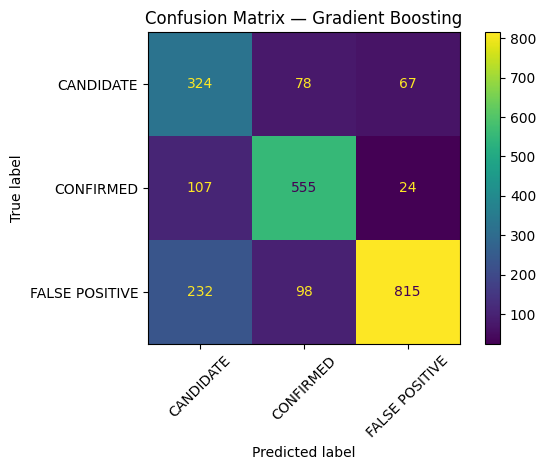

,importance
koi_prad,0.323030
koi_period,0.245565
koi_depth,0.156517
koi_duration,0.108680
koi_kepmag,0.049907
koi_teq,0.043468
koi_steff,0.028608
koi_slogg,0.015490
koi_time0bk,0.015156
koi_srad,0.013579


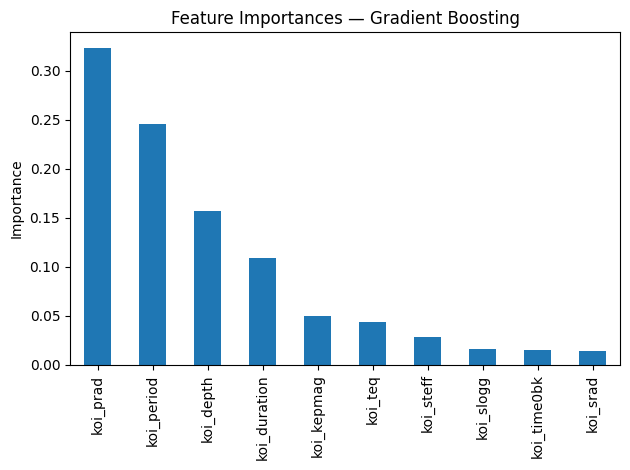

Saved model bundle: C:\Roger\goals\creating\blog\NASA-Space-Apps\models\gradient_boosting.pkl

=== RANDOM_FOREST ===
Accuracy (75/25): 0.747
                precision    recall  f1-score   support

     CANDIDATE       0.53      0.43      0.48       469
     CONFIRMED       0.75      0.81      0.78       686
FALSE POSITIVE       0.81      0.84      0.83      1145

      accuracy                           0.75      2300
     macro avg       0.70      0.69      0.69      2300
  weighted avg       0.74      0.75      0.74      2300



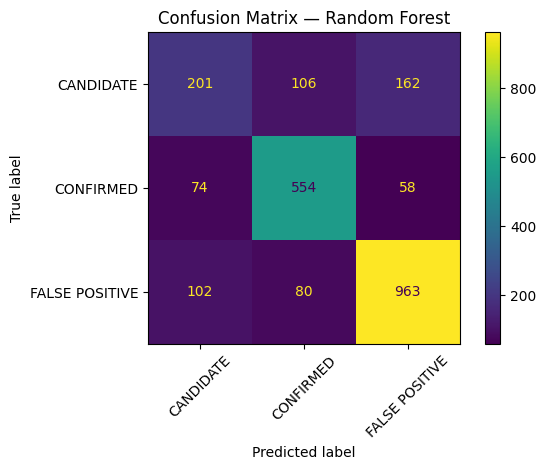

,importance
koi_prad,0.179904
koi_depth,0.141356
koi_period,0.125840
koi_duration,0.104826
koi_teq,0.101670
koi_kepmag,0.079230
koi_time0bk,0.074529
koi_steff,0.070160
koi_srad,0.062145
koi_slogg,0.060339


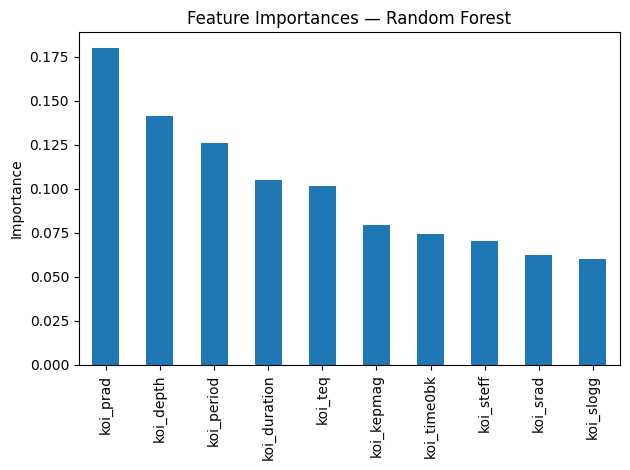

Saved model bundle: C:\Roger\goals\creating\blog\NASA-Space-Apps\models\random_forest.pkl

=== XGBOOST ===
Accuracy (75/25): 0.748
                precision    recall  f1-score   support

     CANDIDATE       0.50      0.69      0.58       469
     CONFIRMED       0.77      0.81      0.79       686
FALSE POSITIVE       0.90      0.73      0.81      1145

      accuracy                           0.75      2300
     macro avg       0.72      0.75      0.73      2300
  weighted avg       0.78      0.75      0.76      2300



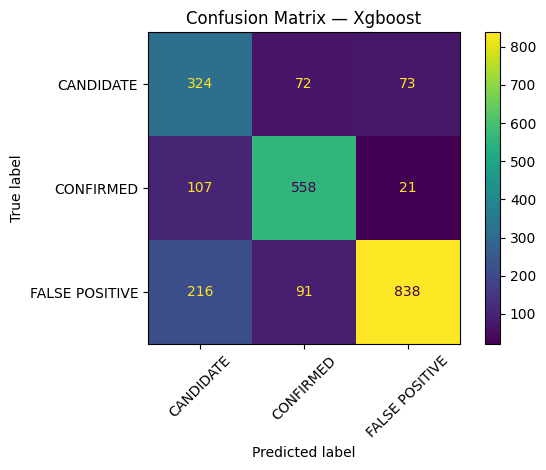

,importance
koi_prad,0.248606
koi_period,0.175291
koi_depth,0.130696
koi_duration,0.086944
koi_teq,0.082114
koi_kepmag,0.066426
koi_steff,0.058170
koi_srad,0.056801
koi_slogg,0.053890
koi_time0bk,0.041062


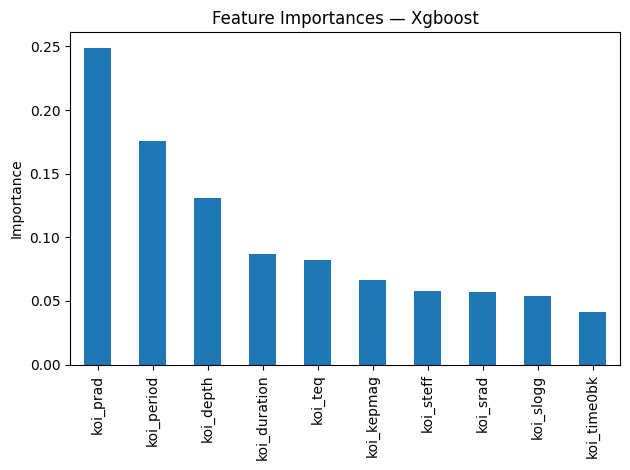

Saved model bundle: C:\Roger\goals\creating\blog\NASA-Space-Apps\models\xgboost.pkl
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6900, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

=== LIGHTGBM ===
Accuracy (75/25): 0.759
                precision    recall  f1-score   support

     CANDIDATE       0.53      0.58      0.55       469
     CONFIRMED       0.79      0.80      0.79       686
FALSE POSITIVE       0.85      0.81      0.83      1145

      accuracy                           0.76      2300
     macro avg       0.72      0.73      0.72      2300
  weighted avg       0.77      0.76      0.76      2300



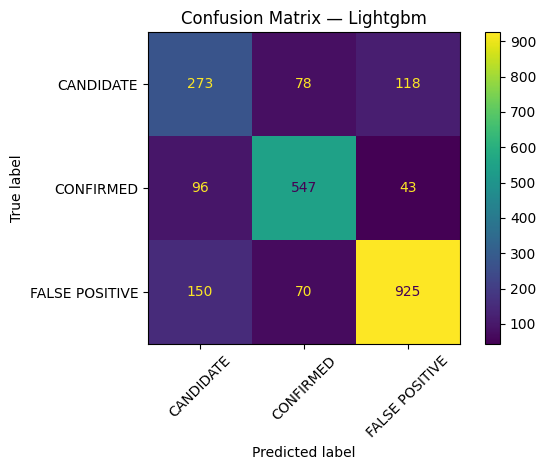

,importance
koi_duration,6758
koi_kepmag,6357
koi_depth,6173
koi_steff,5814
koi_period,5422
koi_prad,5304
koi_time0bk,5272
koi_teq,4589
koi_srad,4230
koi_slogg,4081


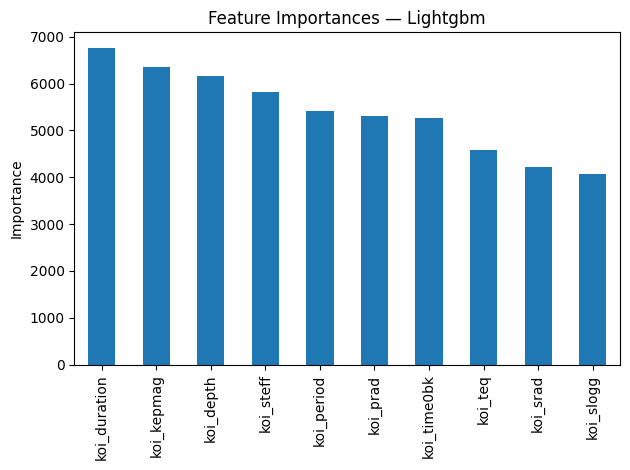

Saved model bundle: C:\Roger\goals\creating\blog\NASA-Space-Apps\models\lightgbm.pkl
💾 Saved ensemble predictions (25% test with IDs, features, per-model preds, Actual): data/koi_testing_sample\test_predictions_ensemble.csv

Model leaderboard (by accuracy):
            model  accuracy                       bundle
         lightgbm  0.758696          models\lightgbm.pkl
          xgboost  0.747826           models\xgboost.pkl
    random_forest  0.746957     models\random_forest.pkl
gradient_boosting  0.736522 models\gradient_boosting.pkl


In [9]:
# Adjusted training/eval loop + merged predictions save
import os
import pandas as pd

artifacts = []
preds_frames = []

# Use sample_weights if you created them earlier; otherwise None
try:
    sw = sample_weights
except NameError:
    sw = None

for name, mdl in models.items():
    art = evaluate_and_save(
        name, mdl,
        X_train, y_train,
        X_test, y_test,
        feature_cols,
        le, target_col,
        ids_te=ids_test,          # <- keep kepid/kepler_name aligned with test set
        out_dir="models",
        save_preds_csv=False,      # per-model CSVs optional; we will save a single merged CSV below
        sample_weight=sw,
        save_plots=False
    )
    artifacts.append({"model": name, "accuracy": art["accuracy"], "bundle": art["bundle_path"]})
    if art["preds_df"] is not None:
        # Keep only IDs, this model's prediction, and Actual to merge later
        preds_frames.append(art["preds_df"][["kepid", "kepler_name", name, "Actual"]])

# ----- Merge all model predictions into one table -----
if preds_frames:
    # Start with IDs + Actual from the first model
    merged = preds_frames[0][["kepid", "kepler_name", "Actual"]].drop_duplicates().copy()
    # Add each model's prediction column
    for dfm in preds_frames:
        merged = merged.merge(dfm.drop(columns=["Actual"]), on=["kepid", "kepler_name"], how="left")

    # Add the feature columns for the 25% test split
    feats_with_ids = X_test.reset_index(drop=True).copy()
    feats_with_ids["kepid"] = ids_test.reset_index(drop=True)["kepid"].values
    feats_with_ids["kepler_name"] = ids_test.reset_index(drop=True)["kepler_name"].values
    merged = merged.merge(
        feats_with_ids[["kepid", "kepler_name"] + feature_cols],
        on=["kepid", "kepler_name"],
        how="left"
    )

    # Optional: pretty column names to match your sample
    pretty_map = {
        "gradient_boosting": "Gradient Boosting BM",
        "xgboost": "XGBoost",
        "lightgbm": "LightGBM",
        "random_forest": "RandomForest",
    }
    merged = merged.rename(columns=pretty_map)

    # Reorder: IDs → features → model preds → Actual
    id_cols_out = ["kepid", "kepler_name"]
    model_cols_pretty = [pretty_map.get(k, k) for k in models.keys()]
    ordered_cols = id_cols_out + feature_cols + model_cols_pretty + ["Actual"]
    merged = merged[ordered_cols]

    # Save the single CSV your app can load
    save_dir = "data/koi_testing_sample"
    os.makedirs(save_dir, exist_ok=True)
    out_csv = os.path.join(save_dir, "test_predictions_ensemble.csv")
    merged.to_csv(out_csv, index=False)
    print(f"💾 Saved ensemble predictions (25% test with IDs, features, per-model preds, Actual): {out_csv}")

# Optional: quick leaderboard
leaderboard = pd.DataFrame(artifacts).sort_values("accuracy", ascending=False)
print("\nModel leaderboard (by accuracy):")
print(leaderboard.to_string(index=False))


In [9]:

# Example: Load a saved pickle and run predict on a small batch (first 5 rows of X_test)
from pathlib import Path
import pickle

example_model = "gradient_boosting"  # change to 'xgboost' or 'lightgbm' if available
pkl_path = Path("models") / f"{example_model}.pkl"

if pkl_path.exists():
    with open(pkl_path, "rb") as f:
        bundle = pickle.load(f)
    mdl = bundle["model"]
    fe_cols = bundle["feature_cols"]
    le_loaded = bundle["label_encoder"]
    
    # Predict and map back to class names
    y_pred = mdl.predict(X_test[:5])
    print("Pred (encoded):", y_pred)
    print("Pred (labels):", le_loaded.inverse_transform(y_pred))
else:
    print(f"Model pickle not found at: {pkl_path}")


Pred (encoded): [1 2 1 2 2]
Pred (labels): ['CONFIRMED' 'FALSE POSITIVE' 'CONFIRMED' 'FALSE POSITIVE'
 'FALSE POSITIVE']


In [15]:
# ===========================================
# 🔭 Merge prediction summary with KOI scores
# ===========================================
import pandas as pd

# --- Load your model results dataset (inline or CSV) ---
data = """kepid,kepler_name,Gradient Boosting,RandomForest,XGBoost,LightGBM,Actual
6343170,Kepler-1230 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
8164012,Kepler-1106 b,FALSE POSITIVE,FALSE POSITIVE,CONFIRMED,CONFIRMED,CONFIRMED
11512246,Kepler-23 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
1849702,Kepler-1854 b,CONFIRMED,CONFIRMED,CONFIRMED,CANDIDATE,CONFIRMED
10468885,Kepler-1284 b,CANDIDATE,FALSE POSITIVE,CANDIDATE,CANDIDATE,CONFIRMED
5780885,Kepler-7 b,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,CONFIRMED
9022166,Kepler-368 c,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
5175024,Kepler-1279 b,CANDIDATE,CANDIDATE,CANDIDATE,CANDIDATE,CONFIRMED
6392727,Kepler-703 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
3103227,Kepler-1550 b,CANDIDATE,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
8013439,Kepler-381 b,CANDIDATE,CONFIRMED,CANDIDATE,CONFIRMED,CONFIRMED
10723367,Kepler-375 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
10545066,Kepler-528 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
3847138,Kepler-556 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
4548098,Kepler-1982 b,CANDIDATE,CANDIDATE,CANDIDATE,CANDIDATE,CONFIRMED
11394027,Kepler-1664 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9898017,Kepler-1960 b,FALSE POSITIVE,FALSE POSITIVE,CANDIDATE,FALSE POSITIVE,CONFIRMED
3234843,Kepler-405 c,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
3942670,Kepler-147 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9941859,Kepler-178 c,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
6922244,Kepler-8 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
11402995,Kepler-481 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9475552,Kepler-1315 c,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9730163,Kepler-445 d,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9112931,Kepler-1161 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
10153855,Kepler-1037 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9823519,Kepler-1350 c,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
10925104,Kepler-114 d,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9892816,Kepler-342 d,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
9881662,Kepler-140 b,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
"""

from io import StringIO
df_preds = pd.read_csv(StringIO(data))

# --- Load the KOI dataset (contains koi_score) ---
koi_path = "data/Kepler Object of Interest.xlsx"
df_koi = pd.read_excel(koi_path)

# --- Normalize column names ---
df_koi.columns = df_koi.columns.str.strip().str.lower()
df_preds.columns = df_preds.columns.str.strip().str.lower()

# --- Select only the relevant fields for merging ---
merge_fields = ["kepid", "koi_score"] if "koi_score" in df_koi.columns else [c for c in df_koi.columns if "score" in c]
df_koi_sub = df_koi[["kepid"] + merge_fields[1:]]

# --- Left join ---
df_merged = df_preds.merge(df_koi_sub, on="kepid", how="left")

# --- Save result ---
out_path = "app/data/koi_predictions_with_scores.csv"
df_merged.to_csv(out_path, index=False)
print(f"✅ Merged dataset saved to: {out_path}")
print(df_merged.head(5))



✅ Merged dataset saved to: app/data/koi_predictions_with_scores.csv
      kepid    kepler_name gradient boosting    randomforest    xgboost  \
0   6343170  Kepler-1230 b         CONFIRMED       CONFIRMED  CONFIRMED   
1   8164012  Kepler-1106 b    FALSE POSITIVE  FALSE POSITIVE  CONFIRMED   
2  11512246    Kepler-23 b         CONFIRMED       CONFIRMED  CONFIRMED   
3  11512246    Kepler-23 b         CONFIRMED       CONFIRMED  CONFIRMED   
4  11512246    Kepler-23 b         CONFIRMED       CONFIRMED  CONFIRMED   

    lightgbm     actual  koi_score  
0  CONFIRMED  CONFIRMED      0.998  
1  CONFIRMED  CONFIRMED      1.000  
2  CONFIRMED  CONFIRMED      0.996  
3  CONFIRMED  CONFIRMED      1.000  
4  CONFIRMED  CONFIRMED      1.000  
